In [1]:
!mkdir %userprofile%\.kaggle
!copy kaggle.json %userprofile%\.kaggle\

A subdirectory or file C:\Users\001\.kaggle already exists.


        1 file(s) copied.


In [ ]:
!kaggle datasets download -d dmitrybabko/speech-emotion-recognition-en

The following resources helped me in undertsanding audio data and how to extract relevant features from them as this was my ever first interaction with audio data in machine learning projects

https://www.kaggle.com/code/shivamburnwal/speech-emotion-recognition/notebook

https://www.kaggle.com/code/mostafaabdlhamed/speech-emotion-recognition-97-25-accuracy

https://github.com/nicknochnack/DeepAudioClassification/blob/main/AudioClassification.ipynb

# Imports

In [1]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import IPython.display as ipd
from IPython.display import Audio

import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout, BatchNormalization, Conv2D,MaxPooling2D, AveragePooling1D
from tensorflow.keras.metrics import Precision, Recall, Accuracy
from tensorflow.keras.optimizers import SGD

In [2]:
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 200

In [3]:
Ravdess = "./speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24/"
Crema = "./speech-emotion-recognition-en/Crema/"
Tess = "./speech-emotion-recognition-en/Tess/"
Savee = "./speech-emotion-recognition-en/Savee/"

# Ravdess Dataset

In [4]:
file_paths_ravdess = []
file_emotions_ravdess = []
actors = os.listdir(Ravdess)
for actor in actors:
    files = os.listdir(Ravdess+actor)
    for file in files:
        file_part = file.split('.')
        file_part_2 = file_part[0].split('-')
        emotion = int(file_part_2[2])
        file_emotions_ravdess.append(emotion)
        file_paths_ravdess.append(Ravdess+actor+'/'+file)
ravdess_df = pd.DataFrame(zip(file_emotions_ravdess,file_paths_ravdess),columns=['Emotions','Paths'])
ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
ravdess_df.head()

Emotions  \
0  neutral   
1  neutral   
2  neutral   
3  neutral   
4     calm   

                                                                                                 Paths  
0  ./speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-01-01.wav  
1  ./speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-02-01.wav  
2  ./speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24/Actor_01/03-01-01-01-02-01-01.wav  
3  ./speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24/Actor_01/03-01-01-01-02-02-01.wav  
4  ./speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24/Actor_01/03-01-02-01-01-01-01.wav

# Crema Dataset

In [5]:
files = os.listdir(Crema)
file_paths_crema = []
file_emotions_crema = []
for file in files:
    file_part = file.split('.')
    file_part_2 = file_part[0].split('_')
    emotion = file_part_2[2]
    if emotion == 'SAD':
        file_emotions_crema.append('sad')
    elif emotion == 'ANG':
        file_emotions_crema.append('angry')
    elif emotion == 'DIS':
        file_emotions_crema.append('disgust')
    elif emotion == 'FEA':
        file_emotions_crema.append('fear')
    elif emotion == 'HAP':
        file_emotions_crema.append('happy')
    elif emotion == 'NEU':
        file_emotions_crema.append('neutral')
    else:
        file_emotions_crema.append('Unknown')
    file_paths_crema.append(Crema+file)

crema_df = pd.DataFrame(zip(file_emotions_crema,file_paths_crema),columns=['Emotions','Paths'])
crema_df.head()

Emotions                                                      Paths
0    angry  ./speech-emotion-recognition-en/Crema/1001_DFA_ANG_XX.wav
1  disgust  ./speech-emotion-recognition-en/Crema/1001_DFA_DIS_XX.wav
2     fear  ./speech-emotion-recognition-en/Crema/1001_DFA_FEA_XX.wav
3    happy  ./speech-emotion-recognition-en/Crema/1001_DFA_HAP_XX.wav
4  neutral  ./speech-emotion-recognition-en/Crema/1001_DFA_NEU_XX.wav

# Tess Dataset

In [6]:
file_paths_tess = []
file_emotions_tess = []
dirs = os.listdir(Tess)
for d in dirs:
    files = os.listdir(Tess+d)
    emotion_from_dir = d.split('_')[-1].lower()
    emotion_from_dir = 'surprise' if emotion_from_dir=='surprised' else emotion_from_dir # because there is a folder named YAF_pleasant_surprised
    file_emotions_tess+=[emotion_from_dir]*len(files)
    for file in files:
        file_paths_tess.append(Tess+d+'/'+file)
tess_df = pd.DataFrame(zip(file_emotions_tess,file_paths_tess),columns=['Emotions','Paths'])

In [7]:
tess_df.sample(10)

Emotions  \
788     happy   
1440    angry   
228   disgust   
1243      sad   
476      fear   
308   disgust   
1902     fear   
2092    happy   
903   neutral   
2622      sad   

                                                                       Paths  
788       ./speech-emotion-recognition-en/Tess/OAF_happy/OAF_wheat_happy.wav  
1440        ./speech-emotion-recognition-en/Tess/YAF_angry/YAF_fat_angry.wav  
228   ./speech-emotion-recognition-en/Tess/OAF_disgust/OAF_death_disgust.wav  
1243           ./speech-emotion-recognition-en/Tess/OAF_Sad/OAF_food_sad.wav  
476          ./speech-emotion-recognition-en/Tess/OAF_Fear/OAF_kill_fear.wav  
308     ./speech-emotion-recognition-en/Tess/OAF_disgust/OAF_nag_disgust.wav  
1902          ./speech-emotion-recognition-en/Tess/YAF_fear/YAF_mob_fear.wav  
2092       ./speech-emotion-recognition-en/Tess/YAF_happy/YAF_lose_happy.wav  
903    ./speech-emotion-recognition-en/Tess/OAF_neutral/OAF_mood_neutral.wav  
2622          ./speech-emotion-recognition-en/Tess/YAF_sad/YAF_chief_sad.wav

# Savee Dataset

In [8]:
savee_directory_list = os.listdir(Savee)

file_emotions_savee = []
file_paths_savee = []

for file in savee_directory_list:
    file_paths_savee.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotions_savee.append('angry')
    elif ele=='d':
        file_emotions_savee.append('disgust')
    elif ele=='f':
        file_emotions_savee.append('fear')
    elif ele=='h':
        file_emotions_savee.append('happy')
    elif ele=='n':
        file_emotions_savee.append('neutral')
    elif ele=='sa':
        file_emotions_savee.append('sad')
    else:
        file_emotions_savee.append('surprise')
        
savee_df = pd.DataFrame(zip(file_emotions_savee,file_paths_savee), columns=['Emotions','Paths'])

In [9]:
savee_df.sample(10)

Emotions                                              Paths
374     angry   ./speech-emotion-recognition-en/Savee/KL_a15.wav
125     angry   ./speech-emotion-recognition-en/Savee/JE_a06.wav
433   neutral   ./speech-emotion-recognition-en/Savee/KL_n14.wav
371     angry   ./speech-emotion-recognition-en/Savee/KL_a12.wav
355  surprise  ./speech-emotion-recognition-en/Savee/JK_su11.wav
415     happy   ./speech-emotion-recognition-en/Savee/KL_h11.wav
83    neutral   ./speech-emotion-recognition-en/Savee/DC_n24.wav
167     happy   ./speech-emotion-recognition-en/Savee/JE_h03.wav
401      fear   ./speech-emotion-recognition-en/Savee/KL_f12.wav
360     angry   ./speech-emotion-recognition-en/Savee/KL_a01.wav

# Concatenate whole dataframes

In [10]:
data_df = pd.concat([ravdess_df,crema_df,tess_df,savee_df],axis=0)

In [11]:
data_df.sample(10)

Emotions  \
90      angry   
834   neutral   
2844      sad   
1485    angry   
192   disgust   
2054    happy   
52      angry   
424   neutral   
966   disgust   
5030  disgust   

                                                                      Paths  
90                ./speech-emotion-recognition-en/Crema/1002_IEO_ANG_MD.wav  
834   ./speech-emotion-recognition-en/Tess/OAF_neutral/OAF_doll_neutral.wav  
2844              ./speech-emotion-recognition-en/Crema/1035_TSI_SAD_XX.wav  
1485              ./speech-emotion-recognition-en/Crema/1019_IOM_ANG_XX.wav  
192               ./speech-emotion-recognition-en/Crema/1003_ITH_DIS_XX.wav  
2054      ./speech-emotion-recognition-en/Tess/YAF_happy/YAF_half_happy.wav  
52       ./speech-emotion-recognition-en/Tess/OAF_angry/OAF_goose_angry.wav  
424                        ./speech-emotion-recognition-en/Savee/KL_n05.wav  
966               ./speech-emotion-recognition-en/Crema/1012_WSI_DIS_XX.wav  
5030              ./speech-emotion-recognition-en/Crema/1062_IWW_DIS_XX.wav

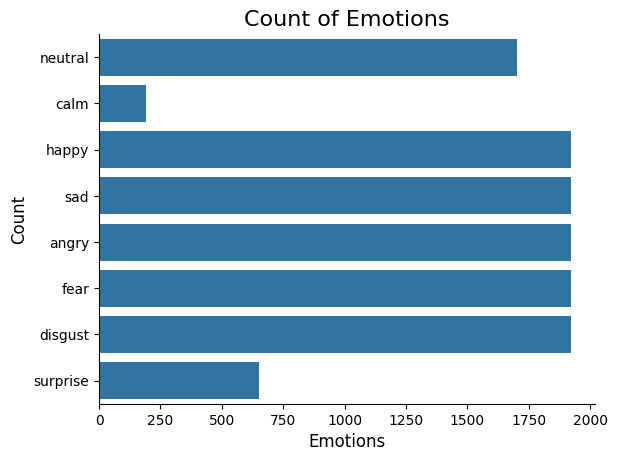

In [12]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

# Try out some audio files

## Using Librosa

In [13]:
def get_random_sample():
    random_sample = data_df.iloc[np.random.randint(len(data_df))]
    return random_sample.Emotions, random_sample.Paths

In [21]:
temp_audio_emotion,temp_audio_path = get_random_sample()

In [22]:
temp_audio_emotion

'fear'

In [23]:
Audio(temp_audio_path)

In [24]:
raw_data, sample_rate = librosa.load(temp_audio_path)

In [25]:
raw_data, sample_rate

(array([0.00346325, 0.00466379, 0.0050708 , ..., 0.03078608, 0.02205369,
        0.        ], dtype=float32),
 22050)

In [26]:
raw_data.shape

(49295,)

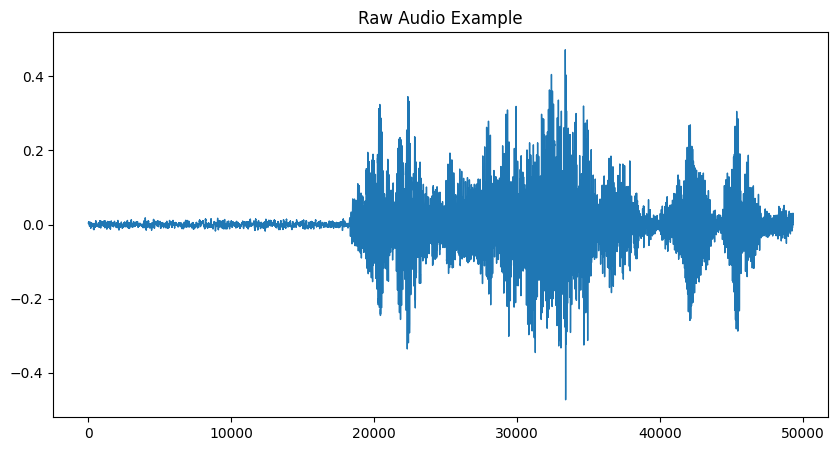

In [27]:
pd.Series(raw_data).plot(figsize=(10,5),lw=1,title='Raw Audio Example')
plt.show()

As you can notice there are alot of silence at the beginning and the end of the audio file.

In [28]:
raw_data_trimmed, index = librosa.effects.trim(raw_data,top_db=20)

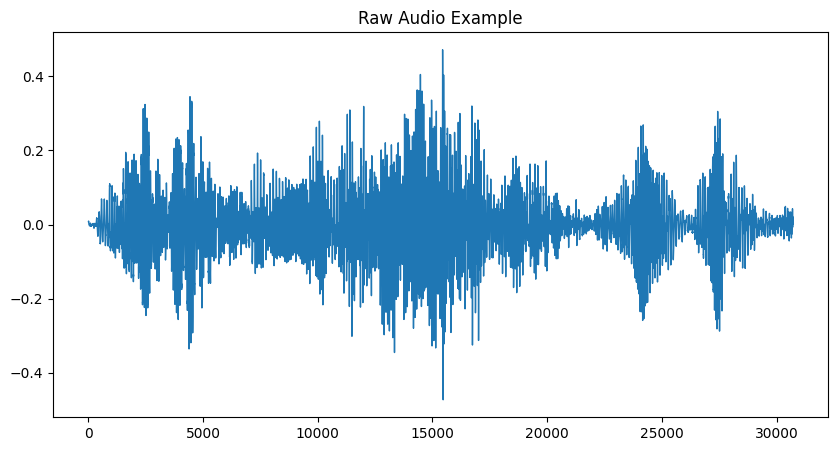

In [29]:
pd.Series(raw_data_trimmed).plot(figsize=(10,5),lw=1,title='Raw Audio Example')
plt.show()

In [30]:
def create_waveplot(data, e):
    pd.Series(data).plot(figsize=(10,5),lw=1,title=f'{e} emotion')
    plt.show()

def create_spectogram(data, sr, e=None, plot=True):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    if plot:
        plt.figure(figsize=(12, 3))
        plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
        librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
        plt.colorbar()
    return Xdb

def create_mel_spectogram(data,sr,e=None, plot=True):
    S = librosa.feature.melspectrogram(y=data,sr=sr,n_mels=128 * 2)
    S_db_mel = librosa.amplitude_to_db(S, ref=np.max)
    if plot:
        fig, ax = plt.subplots(figsize=(10, 5))
        img = librosa.display.specshow(S_db_mel,x_axis='time',y_axis='log',ax=ax)
        ax.set_title('Mel Spectogram Example', fontsize=20)
        fig.colorbar(img, ax=ax, format=f'%0.2f')
        plt.show()
    return S_db_mel

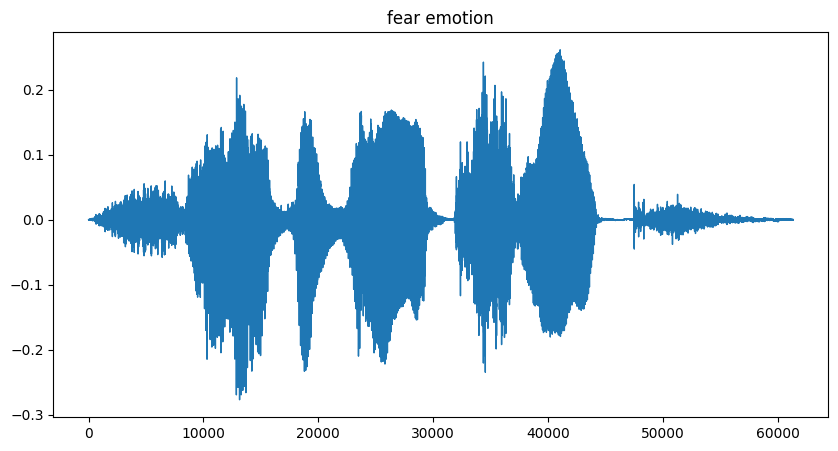

In [31]:
random_sample_emotion,random_sample_path = get_random_sample()
random_sample_data,random_sample_sr = librosa.load(random_sample_path, sr=32000) 
create_waveplot(random_sample_data,random_sample_emotion)

In [32]:
random_sample_data.shape,random_sample_sr

((61357,), 32000)

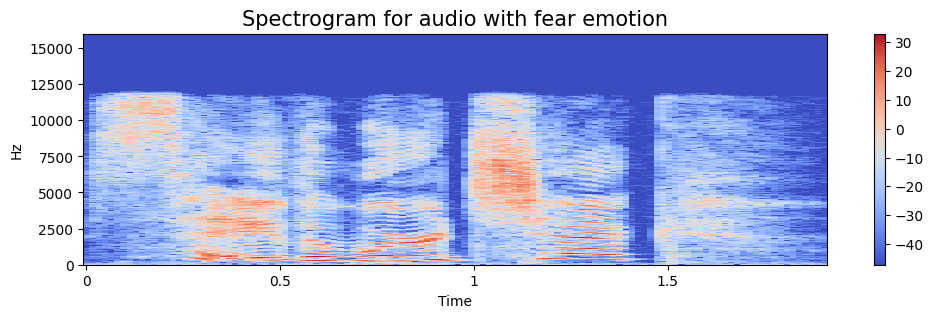

In [33]:
spectogram = create_spectogram(random_sample_data, 32000, random_sample_emotion)

In [34]:
spectogram.shape

(1025, 120)

In [35]:
tf.expand_dims(spectogram, axis=2)

<tf.Tensor: shape=(1025, 120, 1), dtype=float32, numpy=
array([[[-19.59807  ],
        [-13.83039  ],
        [-21.493357 ],
        ...,
        [-13.093632 ],
        [-22.306364 ],
        [-12.780046 ]],

       [[-19.605759 ],
        [-11.682066 ],
        [-10.1526785],
        ...,
        [ -9.493719 ],
        [ -9.991787 ],
        [-12.715405 ]],

       [[-21.181566 ],
        [-12.186869 ],
        [-11.619715 ],
        ...,
        [-10.226216 ],
        [-14.400856 ],
        [-15.683041 ]],

       ...,

       [[-47.13158  ],
        [-47.13158  ],
        [-47.13158  ],
        ...,
        [-47.13158  ],
        [-47.13158  ],
        [-47.13158  ]],

       [[-47.13158  ],
        [-47.13158  ],
        [-47.13158  ],
        ...,
        [-47.13158  ],
        [-47.13158  ],
        [-47.13158  ]],

       [[-47.13158  ],
        [-47.13158  ],
        [-47.13158  ],
        ...,
        [-47.13158  ],
        [-47.13158  ],
        [-47.13158  ]]], dtype=float32

In [36]:
Audio(random_sample_path)

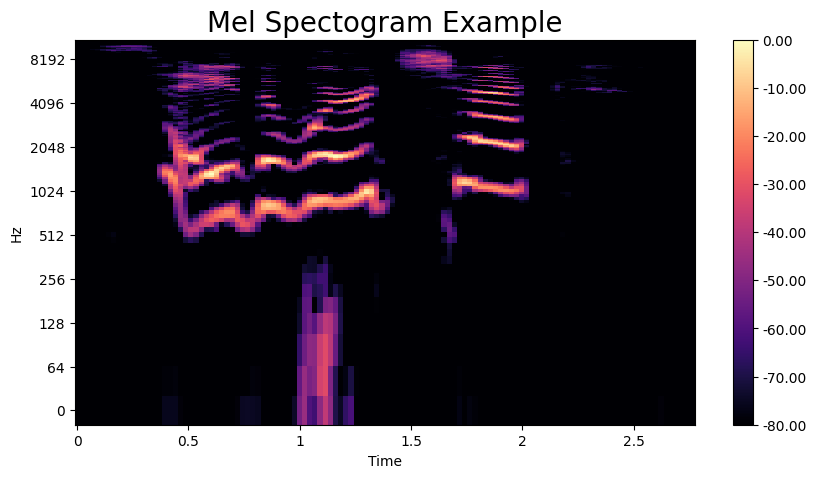

In [37]:
mel_spectogram=create_mel_spectogram(random_sample_data, 32000, random_sample_emotion)

In [38]:
mel_spectogram.shape

(256, 120)

In [39]:
tf.math.reduce_max(mel_spectogram)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

# Lets's view the wave plot and mel spectogram of every emotion

In [40]:
data_df[data_df['Emotions']=='angry'].sample()['Paths'].values[0]

'./speech-emotion-recognition-en/Tess/OAF_angry/OAF_laud_angry.wav'

In [41]:
def view_emotion(df,emotion):
    row = df[df['Emotions']==emotion].sample()
    row_path = row['Paths'].values[0]
    ipd.display(Audio(row_path))
    random_sample_data,random_sample_sr = librosa.load(row_path, sr=32000) 
    create_waveplot(random_sample_data,emotion)
    create_spectogram(random_sample_data,random_sample_sr)
    create_mel_spectogram(random_sample_data,random_sample_sr)

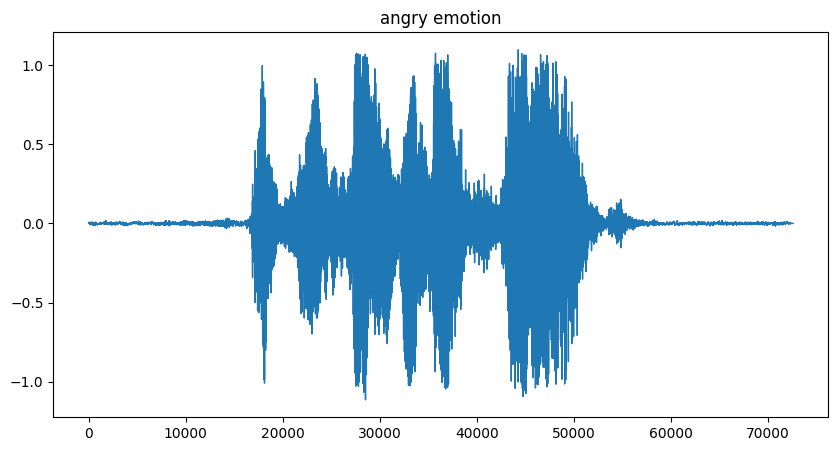

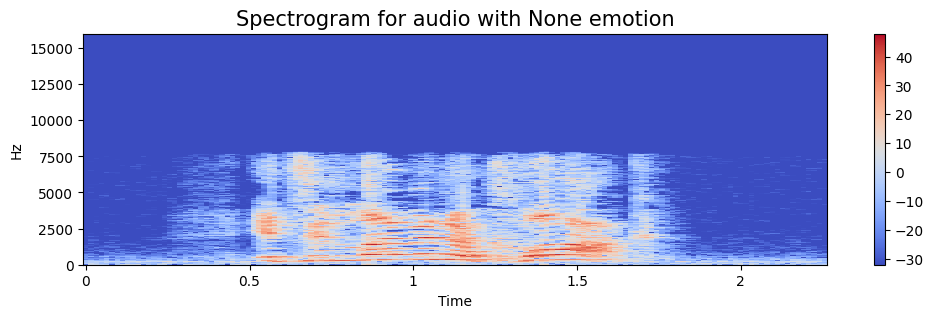

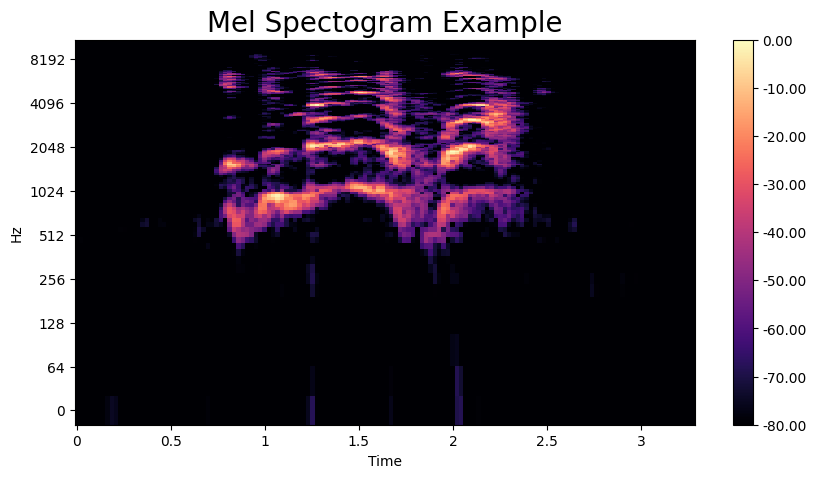

In [42]:
view_emotion(data_df,'angry')

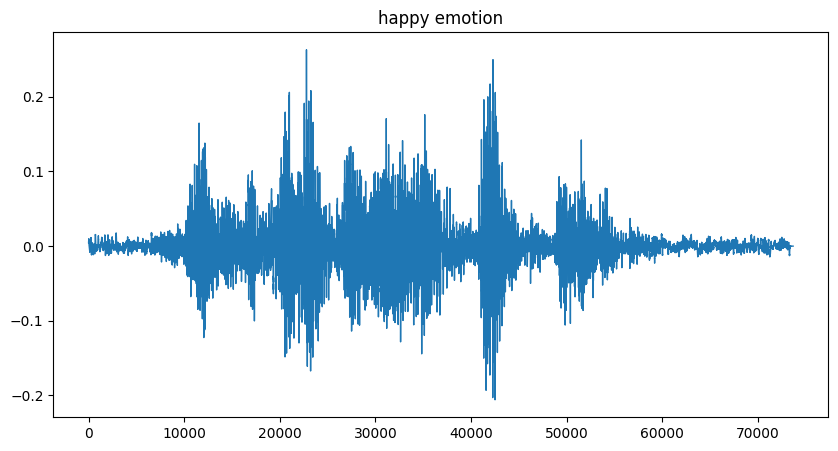

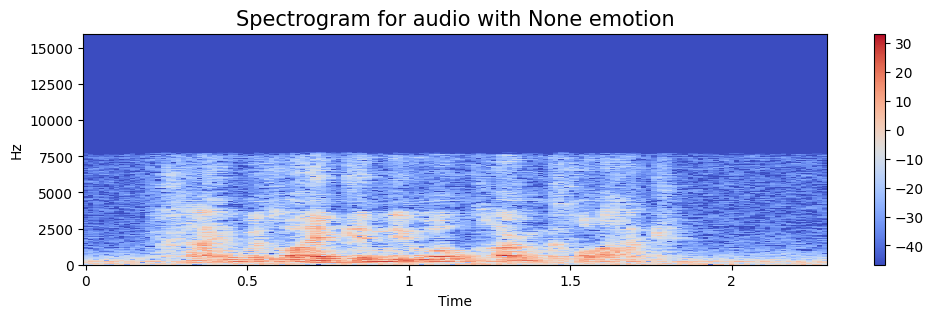

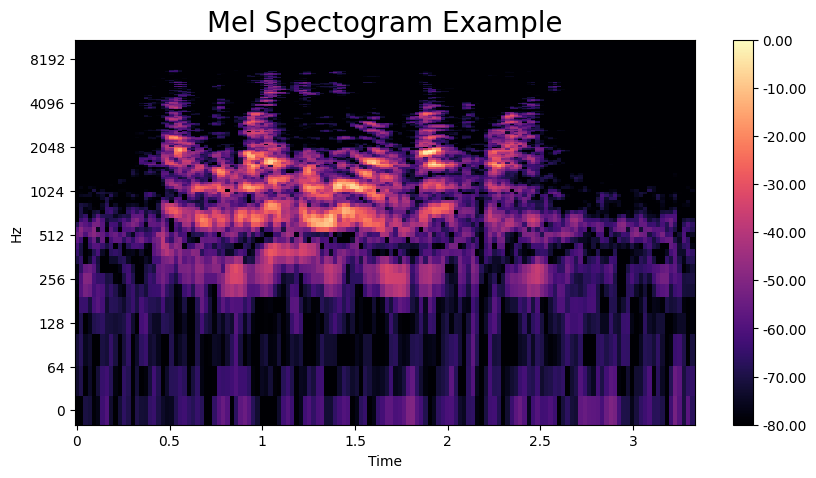

In [43]:
view_emotion(data_df,'happy')

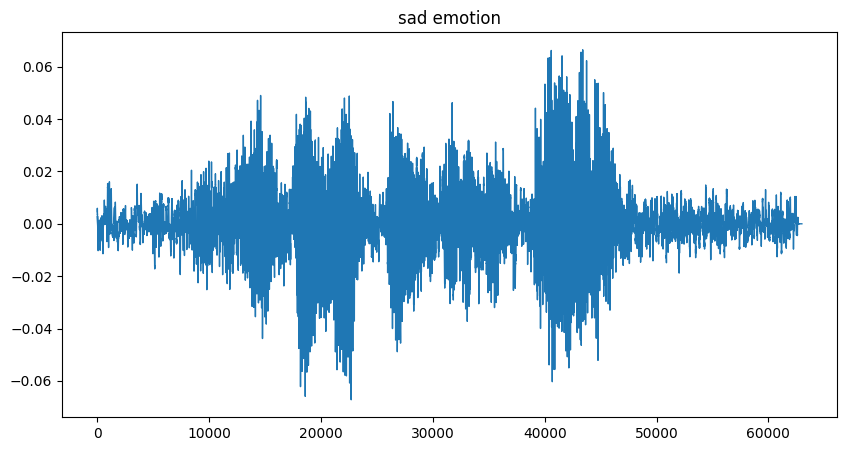

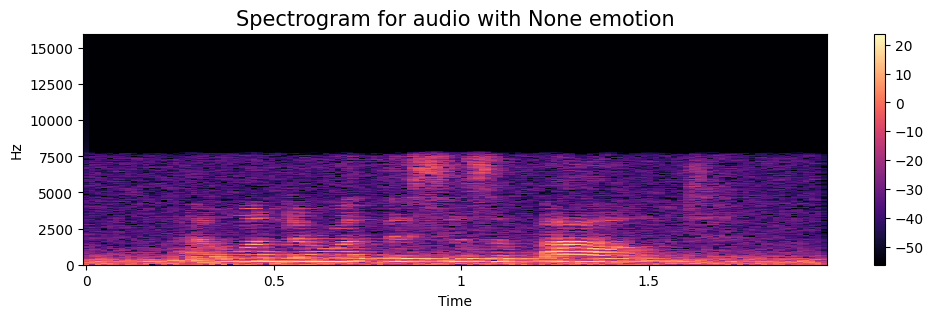

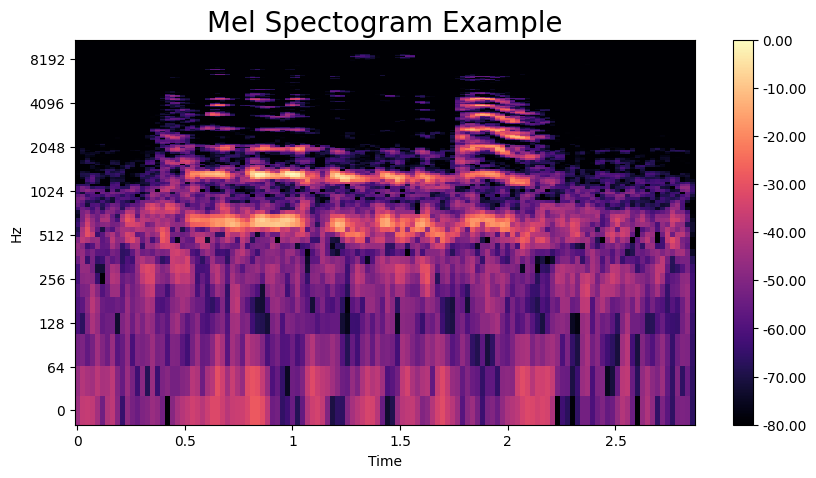

In [44]:
view_emotion(data_df,'sad')

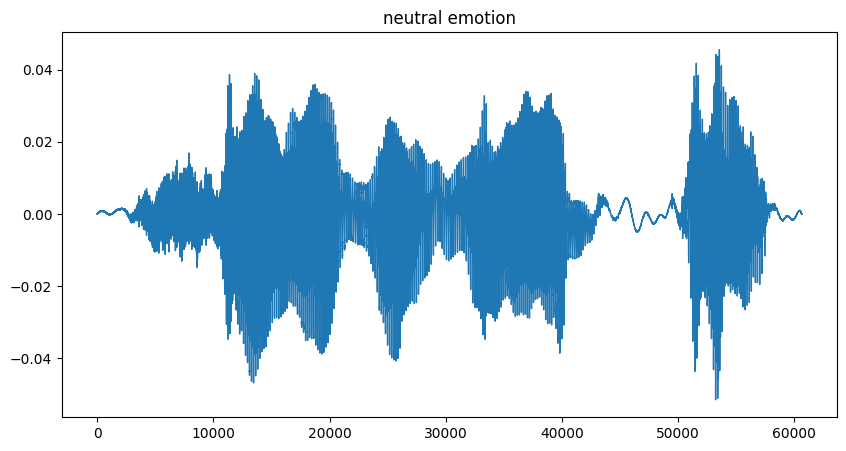

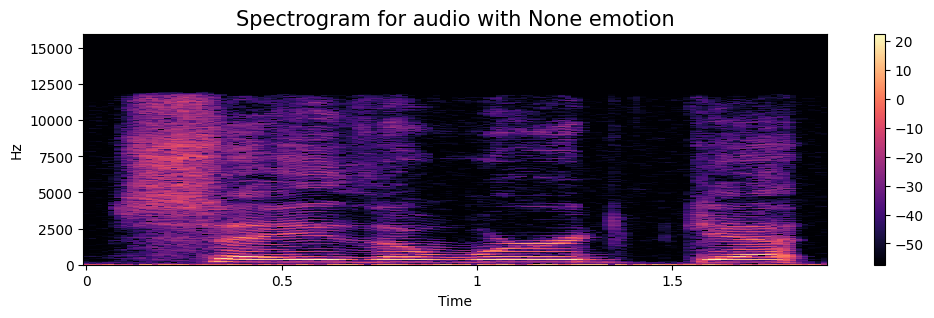

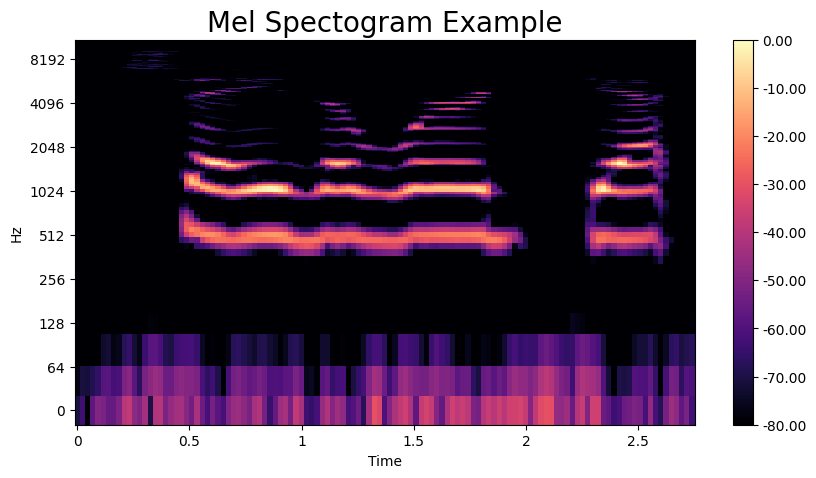

In [45]:
view_emotion(data_df,'neutral')

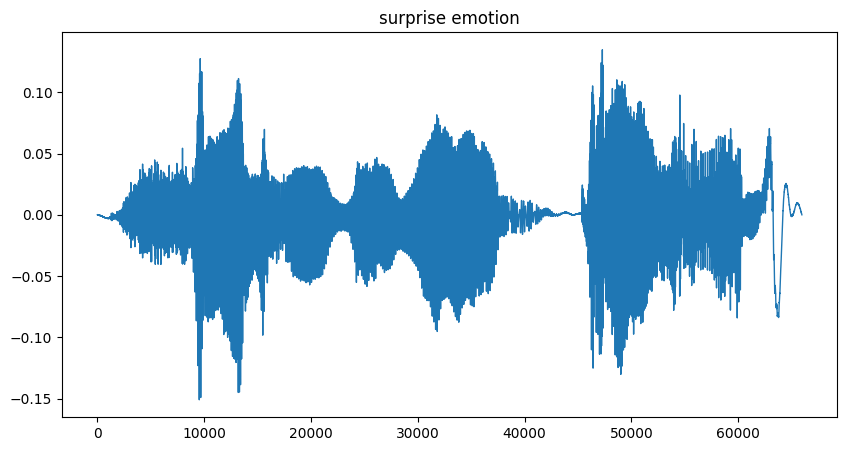

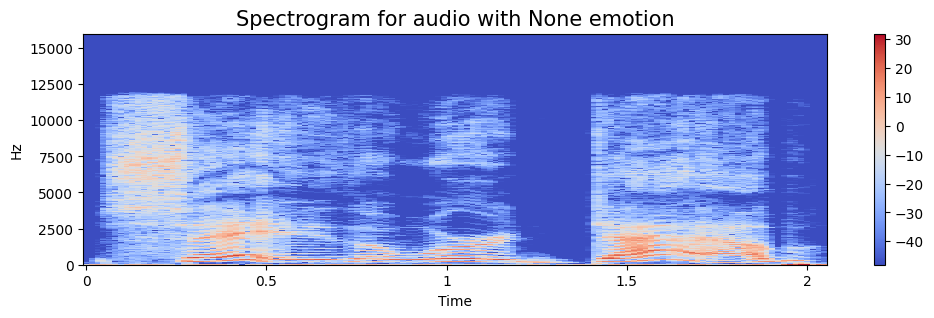

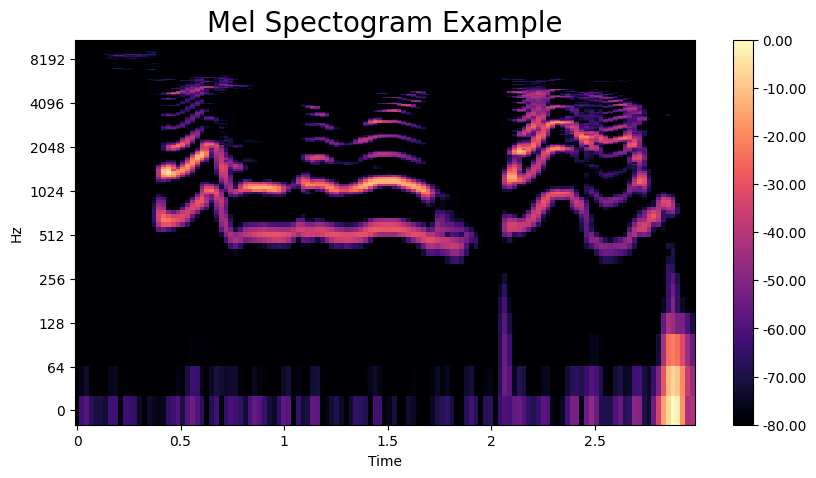

In [46]:
view_emotion(data_df,'surprise')

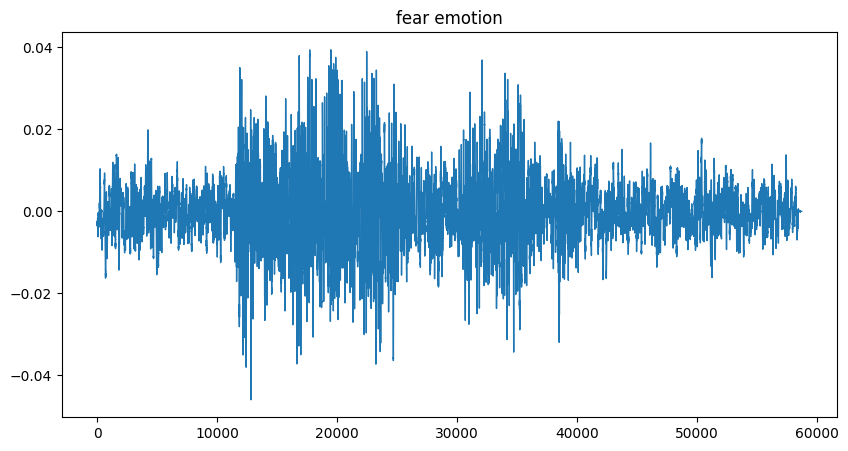

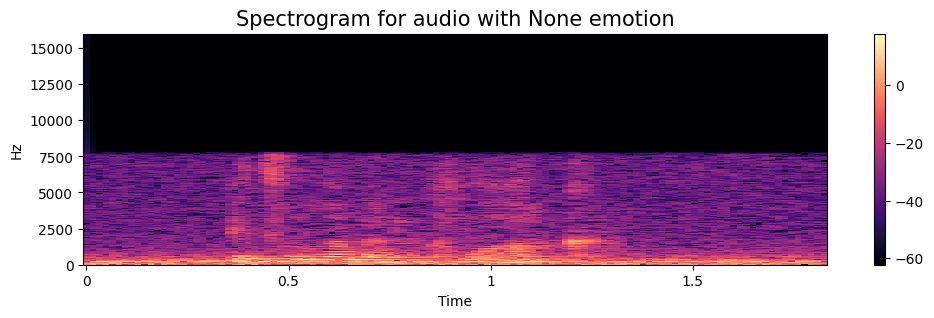

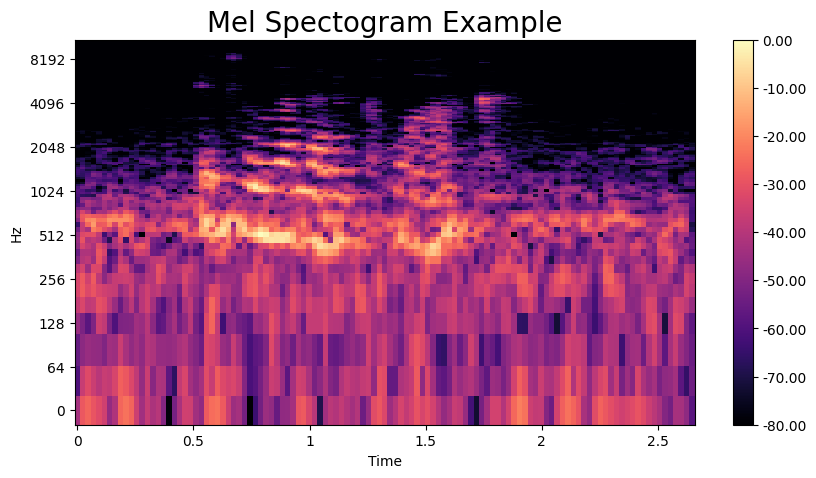

In [47]:
view_emotion(data_df,'fear')

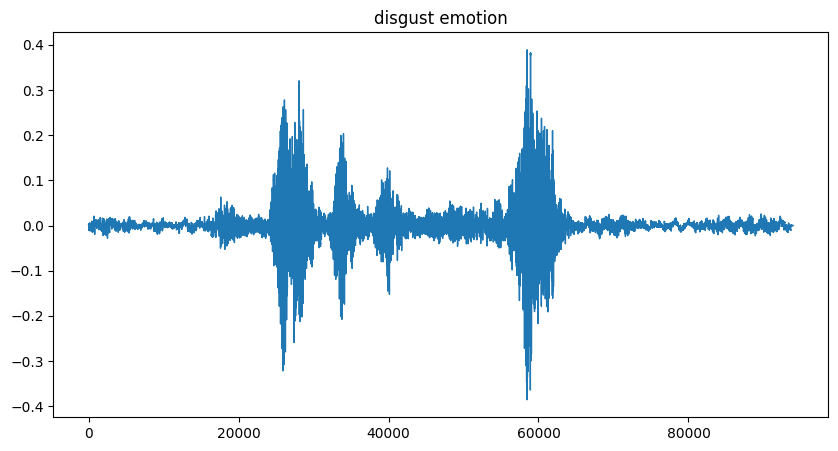

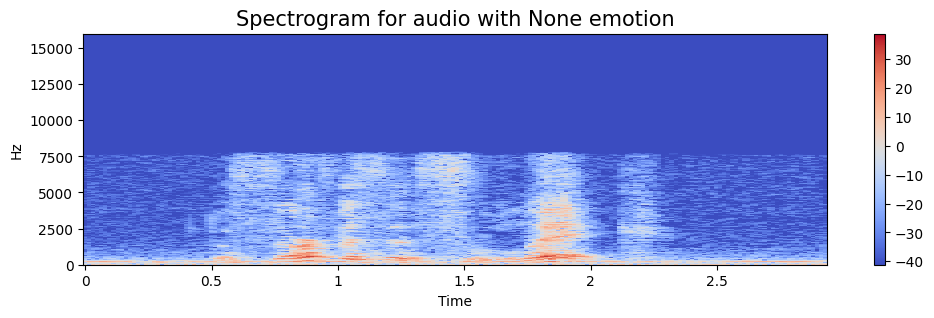

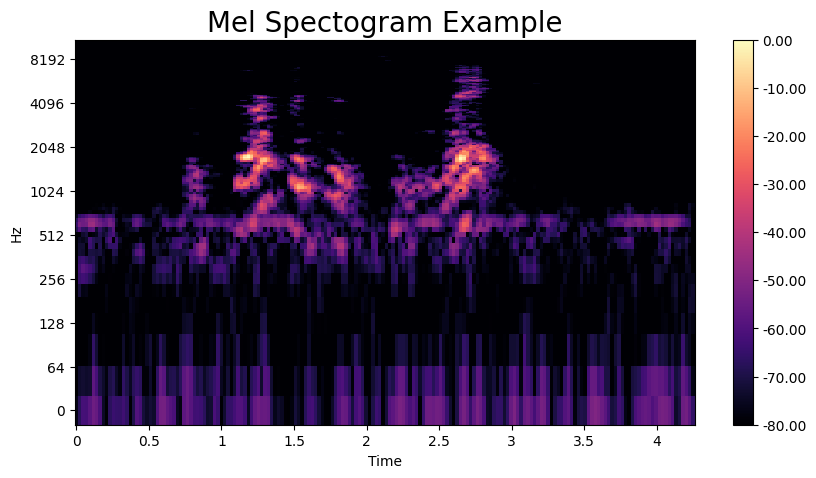

In [48]:
view_emotion(data_df,'disgust')

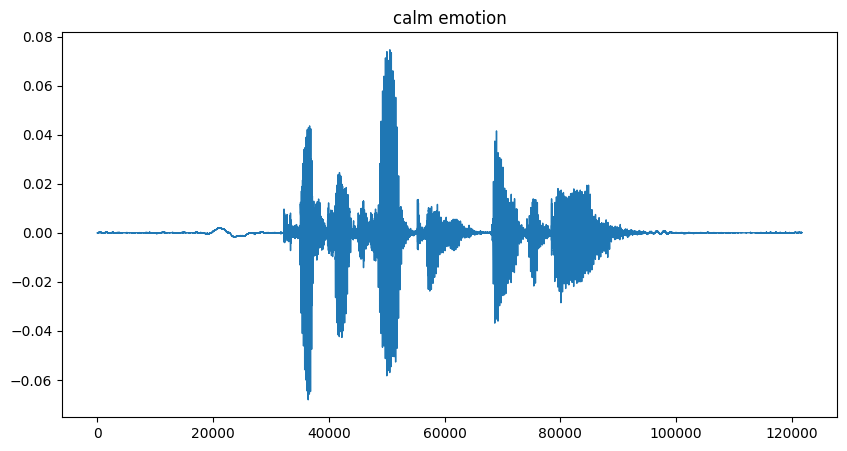

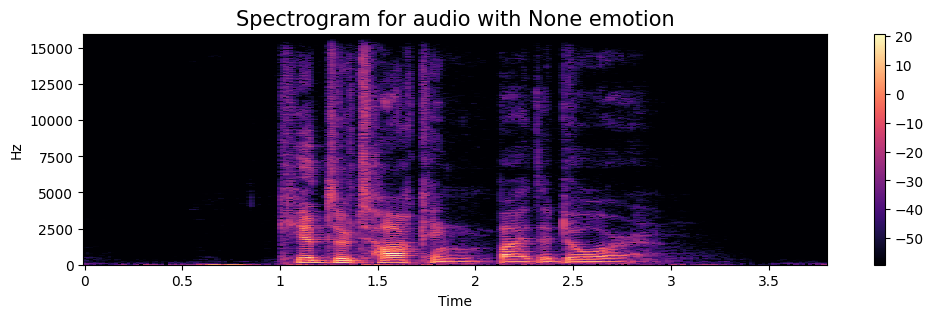

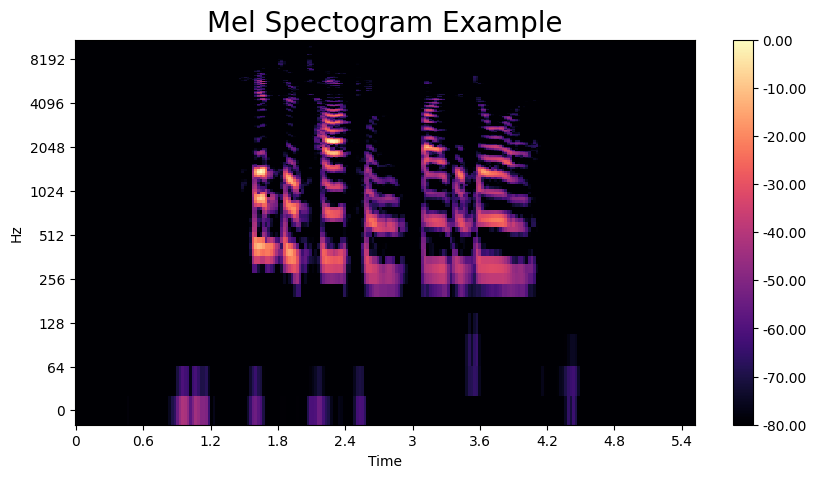

In [49]:
view_emotion(data_df,'calm')

In [50]:
lengths=[]
for row in data_df.iterrows():
    data,sr = librosa.load(row[1]['Paths'])
    lengths.append(len(data))

In [51]:
lengths = np.array(lengths)

In [52]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=57746>

In [53]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=157409>

In [54]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=27653>

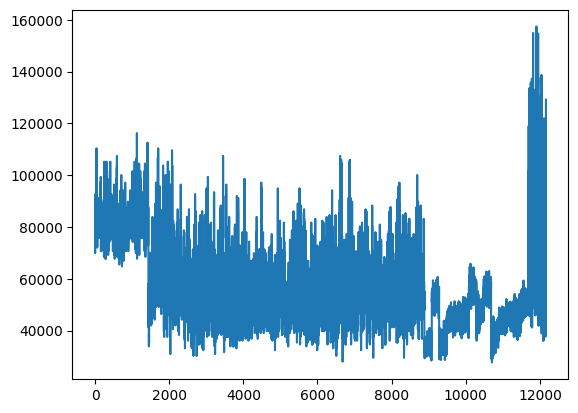

In [55]:
plt.plot(lengths)
plt.show()

In [56]:
lengths = np.sort(lengths)

In [57]:
fixed_size = lengths[int(0.85*len(lengths))]
fixed_size

75781

In [58]:
X_train, X_valid, y_train, y_valid = train_test_split(data_df.Paths.values, data_df.Emotions.values, test_size=0.2, random_state=42, shuffle=True)

In [59]:
len(X_train)

9729

In [60]:
valid_ratio = int(0.5*len(X_valid)) 
X_val, X_test = X_valid[:valid_ratio], X_valid[valid_ratio:]
y_val, y_test = y_valid[:valid_ratio], y_valid[valid_ratio:]

In [61]:
len(X_val),len(X_test)

(1216, 1217)

In [62]:
unique_emotions= data_df.Emotions.unique()
unique_emotions

array(['neutral', 'calm', 'happy', 'sad', 'angry', 'fear', 'disgust',
       'surprise'], dtype=object)

In [63]:
emotion_to_index = {emotion: index for index, emotion in enumerate(unique_emotions)}
emotion_to_index

{'neutral': 0,
 'calm': 1,
 'happy': 2,
 'sad': 3,
 'angry': 4,
 'fear': 5,
 'disgust': 6,
 'surprise': 7}

In [64]:
label_idx = emotion_to_index['angry']
new_label = tf.one_hot(label_idx,depth = len(unique_emotions))
new_label

<tf.Tensor: shape=(8,), dtype=float32, numpy=array([0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)>

In [65]:
batch_size = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE
input_shape = (256, 149, 1)

In [66]:
def preprocess_data(file_path,label):
    raw_data, sr = librosa.load(file_path)
    raw_data = raw_data[:fixed_size]
    zero_padding = tf.zeros([fixed_size] - tf.shape(raw_data), dtype=tf.float32)
    raw_data = tf.concat([zero_padding, raw_data],0)
    mel_spectogram = create_mel_spectogram(np.array(raw_data),sr,plot=False)
    mel_spectogram = tf.expand_dims(mel_spectogram, axis=2)
    mel_spectogram /= (tf.math.reduce_max(mel_spectogram)+1e-6)
    label_idx = emotion_to_index[label]
    new_label = tf.one_hot(label_idx,depth = len(unique_emotions))
    return mel_spectogram, new_label

In [67]:
def preprocess(X,y):
    mel_sps = []
    labels = []
    for file_path,label in zip(X,y):
        mel_sp, new_label = preprocess_data(file_path,label)
        mel_sps.append(mel_sp)
        labels.append(new_label)
    return np.array(mel_sps), np.array(labels)

In [68]:
mel_sps_train, new_labels_train = preprocess(X_train,y_train)

In [69]:
mel_sps_train.shape, new_labels_train.shape

((9729, 256, 149, 1), (9729, 8))

In [70]:
mel_sps_val, new_labels_val = preprocess(X_val,y_val)
mel_sps_test, new_labels_test = preprocess(X_test,y_test)

In [71]:
train_ds = tf.data.Dataset.from_tensor_slices((mel_sps_train,new_labels_train))
val_ds = tf.data.Dataset.from_tensor_slices((mel_sps_val,new_labels_val))
test_ds = tf.data.Dataset.from_tensor_slices((mel_sps_test,new_labels_test))

In [72]:
for x in train_ds:
    print(x[0].shape)
    print(tf.math.reduce_max(x[0]))
    break

(256, 149, 1)
tf.Tensor(0.79230267, shape=(), dtype=float32)


In [73]:
train_ds = train_ds.cache().shuffle(buffer_size=1000).batch(batch_size).prefetch(AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(AUTOTUNE)

# Build Model

In [152]:
model=Sequential()
model.add(Conv2D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv2D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv2D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))

In [153]:
model.compile('Adam', loss='categorical_crossentropy', metrics=[Recall(),Precision(), 'accuracy'])

In [154]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 256, 149, 256)     6656      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 128, 75, 256)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 128, 75, 256)      1638656   
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 64, 38, 256)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 38, 128)       819328    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 32, 19, 128)     

In [155]:
hist = model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
305/305 [==============================] - 58s 189ms/step - loss: 540429.7500 - recall_4: 0.0043 - precision_4: 0.1102 - accuracy: 0.1585 - val_loss: 2.0295 - val_recall_4: 0.0000e+00 - val_precision_4: 0.0000e+00 - val_accuracy: 0.1488
Epoch 2/20
305/305 [==============================] - 58s 190ms/step - loss: 2.0156 - recall_4: 0.0000e+00 - precision_4: 0.0000e+00 - accuracy: 0.1592 - val_loss: 1.9978 - val_recall_4: 0.0000e+00 - val_precision_4: 0.0000e+00 - val_accuracy: 0.1488
Epoch 3/20
 62/305 [=====>........................] - ETA: 44s - loss: 2.0032 - recall_4: 0.0000e+00 - precision_4: 0.0000e+00 - accuracy: 0.1542

KeyboardInterrupt: 

# Data Augmentation

In [74]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

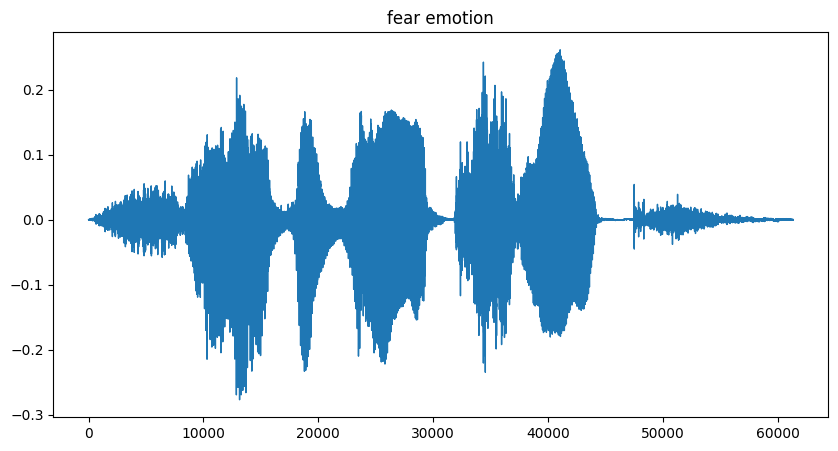

In [75]:
create_waveplot(random_sample_data,random_sample_emotion)
Audio(random_sample_data,rate=sr)

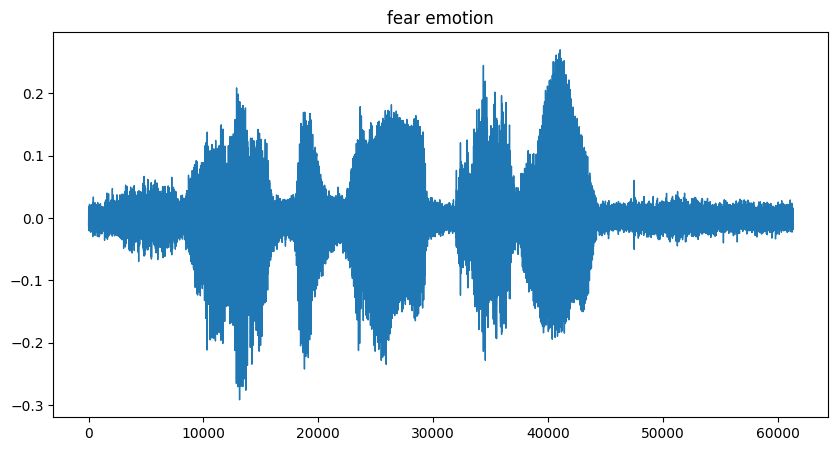

In [76]:
x_noise = noise(random_sample_data)
create_waveplot(x_noise,random_sample_emotion)
Audio(x_noise,rate=sr)

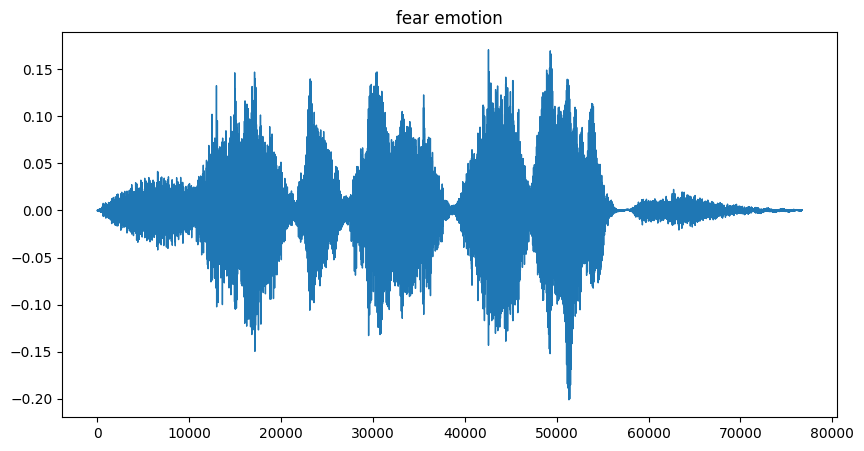

In [77]:
x_stretch = stretch(random_sample_data)
create_waveplot(x_stretch,random_sample_emotion)
Audio(x_stretch,rate=sr)

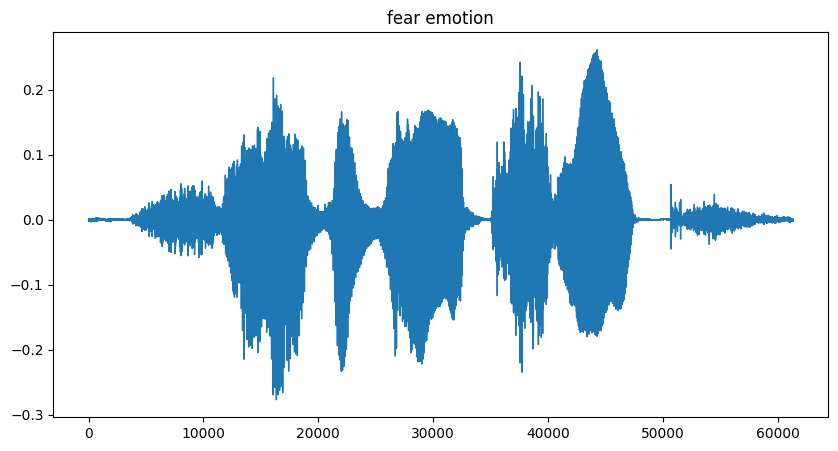

In [78]:
x_shift = shift(random_sample_data)
create_waveplot(x_shift,random_sample_emotion)
Audio(x_shift,rate=sr)

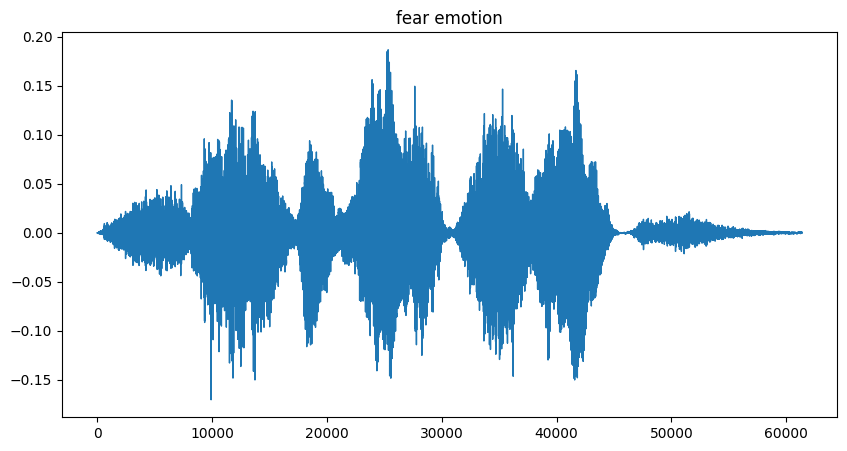

In [79]:
x_pitch = pitch(random_sample_data,sr)
create_waveplot(x_pitch,random_sample_emotion)
Audio(x_pitch,rate=sr)

# Feature Extraction

We will extract 3 features from the audio files and these features are Zero Crossing Rate (ZCR), Root Mean Square Energy (RMSE) and Mel-Frequency Cepstral Coefficients (MFCC):

1. ZCR is like a "jump counter." Imagine someone is very excited and talking really fast. Their voice might go up and down quickly, like they're jumping on that trampoline super fast. If they're sad or bored, they might speak in a slow, steady voice without much jumping. ZCR helps measure this "jumping" in the voice. If there's a lot of "jumping," it might mean the person is excited or angry. If there's not much "jumping," maybe they're calm or sad.

2. RMSE is like a "volume meter." When you're excited or angry, you might talk louder, like you're shouting. If you're scared or surprised, your voice might get very quiet, like a whisper. RMSE measures how loud or soft the sound waves are, which can help the computer guess if you're yelling because you're mad or speaking softly because you're sharing a secret.

3. MFCC tool is like a "voice fingerprint scanner." Just like everyone's fingerprint is different, everyone's voice has special sounds that make it unique. The MFCC listens for these special parts of the voice. It can hear the difference between a laugh and a cry, even if they're both loud. It's very good at picking up the tiny details in how someone talks, which can tell us a lot about how they're feeling.

In [80]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])
    
    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)
    
    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))
    
    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))
    
    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))
    
    return audio

In [99]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  24


In [187]:
import timeit
from tqdm import tqdm
start = timeit.default_timer()
X_new,Y_new=[],[]
for path,emotion,index in tqdm (zip(data_df.Paths,data_df.Emotions,range(data_df.Paths.shape[0]))):
    features=get_features(path)
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        X_new.append(i)
        Y_new.append(emotion)
print('Done')
stop = timeit.default_timer()

print('Time: ', stop - start)

3it [00:00, 21.12it/s]

0 audio has been processed


504it [00:30, 16.11it/s]

500 audio has been processed


1002it [01:01, 16.78it/s]

1000 audio has been processed


1505it [01:31, 22.43it/s]

1500 audio has been processed


2003it [01:58, 20.21it/s]

2000 audio has been processed


2504it [02:25, 19.61it/s]

2500 audio has been processed


3005it [02:48, 18.37it/s]

3000 audio has been processed


3502it [03:13, 21.38it/s]

3500 audio has been processed


4002it [03:38, 19.34it/s]

4000 audio has been processed


4503it [04:04, 20.14it/s]

4500 audio has been processed


5004it [04:31, 16.55it/s]

5000 audio has been processed


5503it [04:58, 14.14it/s]

5500 audio has been processed


6005it [05:24, 19.81it/s]

6000 audio has been processed


6502it [05:51, 18.52it/s]

6500 audio has been processed


7003it [06:19, 20.83it/s]

7000 audio has been processed


7503it [06:47, 15.25it/s]

7500 audio has been processed


8002it [07:18, 16.22it/s]

8000 audio has been processed


8503it [07:48, 14.26it/s]

8500 audio has been processed


9003it [08:17, 25.27it/s]

9000 audio has been processed


9506it [08:41, 28.21it/s]

9500 audio has been processed


10005it [09:03, 21.01it/s]

10000 audio has been processed


10504it [09:30, 17.81it/s]

10500 audio has been processed


11004it [09:54, 22.84it/s]

11000 audio has been processed


11503it [10:19, 19.06it/s]

11500 audio has been processed


12003it [10:51, 11.38it/s]

12000 audio has been processed


12162it [11:02, 18.36it/s]

Done
Time:  662.548776599986


In [ ]:
new_df = pd.DataFrame(X_new)
new_df['Emotions'] = Y_new
new_df.to_csv('emotions.csv', index=False)
new_df.head()

In [82]:
new_df = pd.read_csv('./emotions.csv')
new_df.head()

0         1         2         3         4         5         6  \
0  0.173828  0.264648  0.372559  0.486328  0.625488  0.681152  0.720703   
1  0.268555  0.395020  0.520508  0.518555  0.502930  0.500488  0.493652   
2  0.256348  0.354492  0.471191  0.414062  0.378418  0.373535  0.354492   
3  0.258301  0.385254  0.514160  0.513672  0.506348  0.498047  0.490723   
4  0.247070  0.389648  0.564941  0.642578  0.665527  0.684570  0.676270   

          7         8         9        10        11        12        13  \
0  0.651855  0.562988  0.559082  0.559570  0.567383  0.541016  0.520020   
1  0.490723  0.498047  0.501465  0.519531  0.503418  0.488770  0.485840   
2  0.408691  0.466797  0.522461  0.580566  0.585938  0.562500  0.483398   
3  0.484863  0.491211  0.498047  0.520020  0.525391  0.525391  0.518555   
4  0.666992  0.648926  0.595703  0.528320  0.496582  0.450195  0.521484   

         14        15        16        17        18        19        20  \
0  0.437012  0.421387  0.372070  0.341309  0.308594  0.203613  0.149414   
1  0.478027  0.489258  0.469727  0.449707  0.355957  0.245117  0.168945   
2  0.415527  0.346191  0.292969  0.277344  0.201660  0.143066  0.105469   
3  0.486816  0.481445  0.437988  0.379883  0.283203  0.177246  0.115234   
4  0.551758  0.553223  0.497559  0.396484  0.350586  0.247559  0.180664   

         21        22        23        24        25        26        27  \
0  0.071777  0.047363  0.083984  0.152832  0.169434  0.185059  0.159180   
1  0.075684  0.053223  0.096191  0.164551  0.183105  0.196777  0.163574   
2  0.062988  0.073730  0.136719  0.197266  0.238770  0.252930  0.198242   
3  0.073730  0.085449  0.149414  0.210938  0.256348  0.270508  0.218750   
4  0.107910  0.033203  0.034668  0.081543  0.165527  0.184082  0.187012   

         28        29        30        31        32        33        34  \
0  0.090820  0.073730  0.141113  0.195801  0.223145  0.224121  0.145020   
1  0.113281  0.130371  0.205078  0.259277  0.283203  0.261230  0.172363   
2  0.145996  0.137695  0.185059  0.222656  0.210938  0.180176  0.114258   
3  0.174316  0.173828  0.219238  0.268066  0.267578  0.221191  0.152344   
4  0.145996  0.071289  0.055176  0.049805  0.134277  0.186035  0.210938   

         35        36        37        38        39        40        41  \
0  0.081055  0.057129  0.062988  0.067871  0.077637  0.098145  0.091309   
1  0.108398  0.069336  0.068848  0.094238  0.132324  0.189941  0.180176   
2  0.068848  0.066895  0.070801  0.071289  0.083496  0.072754  0.072754   
3  0.092285  0.072754  0.079590  0.092773  0.137695  0.144043  0.156738   
4  0.208496  0.127930  0.072754  0.054688  0.064453  0.063477  0.083496   

         42        43        44        45        46        47        48  \
0  0.081543  0.067383  0.033691  0.028320  0.025879  0.027344  0.032227   
1  0.151855  0.114258  0.043457  0.038086  0.038574  0.047852  0.054688   
2  0.067871  0.052246  0.049805  0.041016  0.035645  0.040527  0.045410   
3  0.148926  0.105469  0.093750  0.082031  0.075684  0.079590  0.079590   
4  0.113281  0.104492  0.096191  0.068359  0.026855  0.025879  0.021973   

         49        50        51        52        53        54        55  \
0  0.041504  0.045898  0.047852  0.049805  0.044922  0.042969  0.040039   
1  0.061035  0.062500  0.053223  0.070312  0.080078  0.088867  0.088379   
2  0.052734  0.057129  0.060547  0.060547  0.057129  0.060547  0.052734   
3  0.076172  0.072754  0.074219  0.091797  0.102051  0.118164  0.114258   
4  0.024414  0.029297  0.037109  0.042969  0.046387  0.048340  0.047363   

         56        57        58        59        60        61        62  \
0  0.035156  0.032227  0.036621  0.032715  0.036621  0.039062  0.037109   
1  0.082031  0.082520  0.086426  0.080566  0.070801  0.057129  0.044922   
2  0.059082  0.063965  0.057129  0.057617  0.049316  0.046387  0.049316   
3  0.116699  0.129395  0.118164  0.121094  0.107422  0.095215  0.092285   
4  0.044434  0.041504  0.03

In [83]:
new_df.isna().any()

0           False
1           False
2           False
3           False
4           False
            ...  
2372         True
2373         True
2374         True
2375         True
Emotions    False
Length: 2377, dtype: bool

In [84]:
new_df=new_df.fillna(0)
print(new_df.isna().any())
new_df.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


(48648, 2377)

In [85]:
np.sum(new_df.isna())

C:\Users\001\anaconda3\envs\py310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


0           0
1           0
2           0
3           0
4           0
           ..
2372        0
2373        0
2374        0
2375        0
Emotions    0
Length: 2377, dtype: int64

In [86]:
X_all = new_df.iloc[: ,:-1].values
Y_all = new_df['Emotions'].values

In [87]:
encoder = OneHotEncoder()
Y_ohe = encoder.fit_transform(np.array(Y_all).reshape(-1,1)).toarray()

In [88]:
print(Y_ohe.shape)
X_all.shape

(48648, 8)


(48648, 2376)

In [89]:
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(X_all, Y_ohe, random_state=42,test_size=0.2, shuffle=True)
x_train_2.shape, y_train_2.shape, x_test_2.shape, y_test_2.shape

((38918, 2376), (38918, 8), (9730, 2376), (9730, 8))

In [91]:
scaler = StandardScaler()
x_train_2 = scaler.fit_transform(x_train_2)
x_test_2 = scaler.transform(x_test_2)
x_train_2.shape, y_train_2.shape, x_test_2.shape, y_test_2.shape

((38918, 2376), (38918, 8), (9730, 2376), (9730, 8))

In [96]:
model_checkpoint = ModelCheckpoint('best_model1_weights.h5', monitor='val_accuracy', save_best_only=True)
early_stop=EarlyStopping(monitor='val_accuracy',mode='auto',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

In [93]:
x_traincnn =np.expand_dims(x_train_2, axis=2)
x_testcnn= np.expand_dims(x_test_2, axis=2)
x_traincnn.shape, y_train_2.shape, x_testcnn.shape, y_test_2.shape

((38918, 2376, 1), (38918, 8), (9730, 2376, 1), (9730, 8))

In [150]:
x_train_2.shape[1]

2376

In [97]:
model_2 = tf.keras.Sequential([
    Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(x_train_2.shape[1],1)),
    BatchNormalization(),
    MaxPool1D(pool_size=5,strides=2,padding='same'),
    
    Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    BatchNormalization(),
    MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the second max pooling layer
    
    Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    BatchNormalization(),
    MaxPool1D(pool_size=5,strides=2,padding='same'),
    
    Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    BatchNormalization(),
    MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fourth max pooling layer
    
    Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    BatchNormalization(),
    MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fifth max pooling layer
    
    Flatten(),
    Dense(512,activation='relu'),
    BatchNormalization(),
    Dense(8,activation='softmax')
])
model_2.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 2376, 512)         3072      
                                                                 
 batch_normalization_6 (Batc  (None, 2376, 512)        2048      
 hNormalization)                                                 
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 1188, 512)        0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 1188, 512)         1311232   
                                                                 
 batch_normalization_7 (Batc  (None, 1188, 512)        2048      
 hNormalization)                                                 
                                                      

# Training

In [98]:
history=model_2.fit(
    x_traincnn, 
    y_train_2, 
    epochs=15, 
    validation_data=(x_testcnn, y_test_2), 
    batch_size=64,
    callbacks=[early_stop,lr_reduction,model_checkpoint]
)

Epoch 1/15
609/609 [==============================] - 76s 123ms/step - loss: 1.4135 - accuracy: 0.4680 - val_loss: 1.4880 - val_accuracy: 0.4407 - lr: 0.0010
Epoch 2/15
609/609 [==============================] - 75s 123ms/step - loss: 1.1215 - accuracy: 0.5686 - val_loss: 1.1430 - val_accuracy: 0.5559 - lr: 0.0010
Epoch 3/15
609/609 [==============================] - 76s 124ms/step - loss: 0.9764 - accuracy: 0.6268 - val_loss: 1.0444 - val_accuracy: 0.6020 - lr: 0.0010
Epoch 4/15
609/609 [==============================] - 74s 122ms/step - loss: 0.8554 - accuracy: 0.6733 - val_loss: 0.9340 - val_accuracy: 0.6445 - lr: 0.0010
Epoch 5/15
609/609 [==============================] - 74s 122ms/step - loss: 0.7474 - accuracy: 0.7189 - val_loss: 0.9035 - val_accuracy: 0.6663 - lr: 0.0010
Epoch 6/15
609/609 [==============================] - 75s 123ms/step - loss: 0.6403 - accuracy: 0.7624 - val_loss: 0.9488 - val_accuracy: 0.6612 - lr: 0.0010
Epoch 7/15
609/609 [==============================] 

# Evaluation

In [100]:
def plot_loss_acc(history):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')  # Change 'accuracy' to the name of your accuracy metric if different
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Same as above
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [103]:
model_2.evaluate(x_testcnn,y_test_2)

305/305 [==============================] - 5s 17ms/step - loss: 0.1543 - accuracy: 0.9543


[0.1543387770652771, 0.9542651772499084]

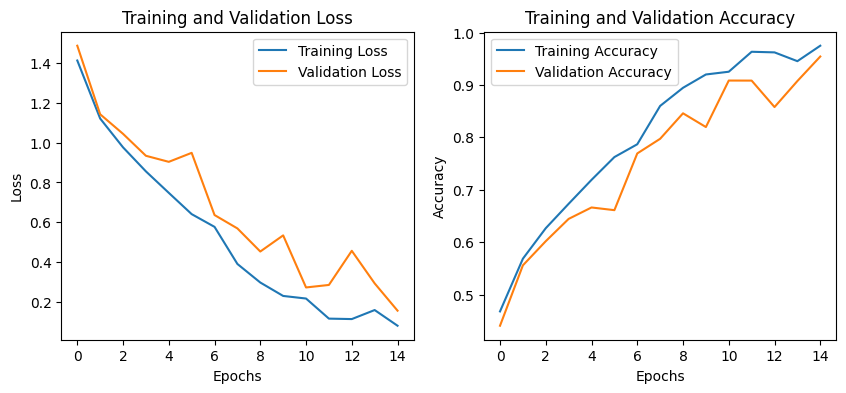

In [101]:
plot_loss_acc(history)

We can train for more epochs and even gain better validation accuracy

In [108]:
y_pred_ohe = model_2.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(y_pred_ohe)
y_test0 = encoder.inverse_transform(y_test_2)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

305/305 [==============================] - 5s 17ms/step


In [109]:
df0.sample(10)

Predicted Labels Actual Labels
2186              sad           sad
3102            angry         angry
1580          neutral       neutral
9276              sad           sad
4384            angry         angry
2281          disgust       disgust
8799             fear       disgust
320           neutral       neutral
5041             calm          calm
6594            happy         happy

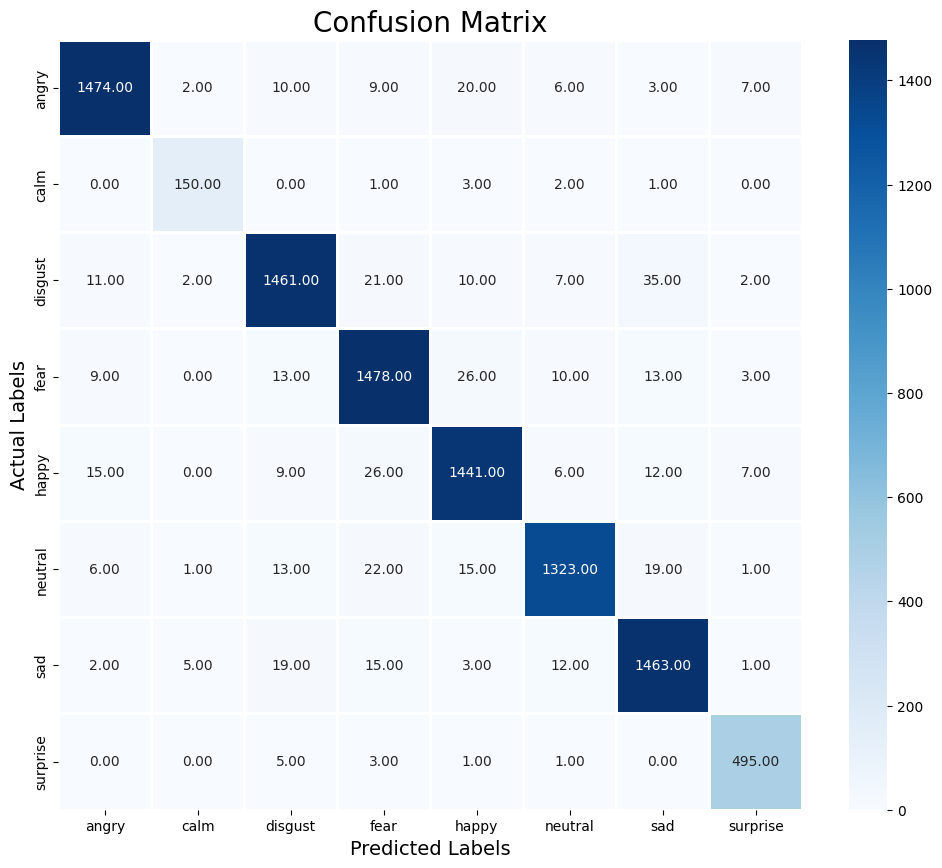

              precision    recall  f1-score   support

       angry       0.97      0.96      0.97      1531
        calm       0.94      0.96      0.95       157
     disgust       0.95      0.94      0.95      1549
        fear       0.94      0.95      0.95      1552
       happy       0.95      0.95      0.95      1516
     neutral       0.97      0.94      0.96      1400
         sad       0.95      0.96      0.95      1520
    surprise       0.96      0.98      0.97       505

    accuracy                           0.95      9730
   macro avg       0.95      0.96      0.95      9730
weighted avg       0.95      0.95      0.95      9730



In [110]:
cm = confusion_matrix(y_test0, y_pred0)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test0, y_pred0))

# Predicting Custom-Made Audio Files

In [198]:
def predict_custom_vns(test_path):
    data,sr = librosa.load(test_path, duration=2.5, offset=0.6)
    features=np.array(extract_features(data))
    features = np.expand_dims(features,axis=0)
    # print(features.shape)
    standardized_features = scaler.transform(features)
    test_sample = np.expand_dims(standardized_features,axis=2)
    # print(test_sample.shape)
    y_pred = model_2.predict(test_sample)
    label = encoder.inverse_transform(y_pred)
    return label

In [199]:
def predict_all_folder(folder_path):
    files = os.listdir(folder_path)
    y_preds = []
    for file in files:
        curr_path = test_folder_path+'/'+file
        ipd.display(Audio(curr_path))
        curr_label = predict_custom_vns(curr_path)
        print(curr_label[0][0])
        y_preds.append(curr_label)
    return y_preds

In [200]:
test_folder_path='./test'

In [201]:
test_preds=predict_all_folder(test_folder_path)

1/1 [==============================] - 0s 13ms/step
fear
